# Particle Swarm Optimization (PSO) for University Timetable Scheduling

## Setup and Imports

In [ ]:
#Requirements
#!pip install deap 
#!pip install pandas tabulate

In [1]:
from deap import base
from deap import creator
from deap import tools
#from tabulate import tabulate (tl3 shaklo msh helw)
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import configparser

## Constants

In [2]:
NUM_COURSES = 60    # 60 course, each level take 15 courses
NUM_LECTURERS = 20
NUM_TIMESLOTS = 10  # 5 timeslots per day over a 5-day week
NUM_ROOMS = 6
POPULATION_SIZE = 1000 #Assume average 200 student per each level
MAX_GENERATIONS = 400
COURSE_HOURS = np.random.randint(1, 4, size=NUM_COURSES)  # Random between 1 to 3 hours per course
POPULAR_COURSE_COMBINATIONS = []

for i in range(0, NUM_COURSES, 15):
    POPULAR_COURSE_COMBINATIONS.append(tuple(range(i, i + 15)))

print(POPULAR_COURSE_COMBINATIONS)

# Constants for days and timeslots
NUM_DAYS = 6
TIMESLOTS_PER_DAY = 8
NUM_TIMESLOTS = NUM_DAYS * TIMESLOTS_PER_DAY
DAYS = ["Satuerday","Sunday", "Monday", "Tuesday", "Wednesday", "Thursday"]
TIMESLOTS = [f"{i+9}:00-{i+10}:00" for i in range(TIMESLOTS_PER_DAY)]

# Let's simulate some data for demonstration
# Each row represents a lecturer's availability over timeslots, 0 means unavailable
LECTURER_AVAILABILITY = np.random.choice([0, 1], (NUM_LECTURERS, NUM_TIMESLOTS), p=[0.2, 0.8])

# Course requirements indicating which lecturer can teach which course
# 0 means the lecturer cannot teach the course, 1 means they can
COURSE_REQUIREMENTS = np.random.choice([0, 1], (NUM_COURSES, NUM_LECTURERS))

# Room capacity 
ROOM_CAPACITY = np.random.randint(10, 100, size=NUM_ROOMS)

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), (15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29), (30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44), (45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)]


In [3]:
# we assumed 16 course, each level take 4 courses 
def course_to_level(course_id):
    for level_index, courses in enumerate(POPULAR_COURSE_COMBINATIONS):
        if course_id in courses:            
            return level_index
    return None  # In case the course_id is not found



## Particle and Problem Encoding

In [4]:
# Create a Particle Class with appropriate attributes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # We aim to minimize the fitness
creator.create("Particle", list, fitness=creator.FitnessMin, best=None, speed=list)

def create_particle(method='random'):
    if method == 'random':
        return create_particle_random()
    elif method == 'level_based':
        return create_particle_level_based()
    else:
        raise ValueError("Unsupported initialization method")

def create_particle_random():
    particle = []
    used_slots = set()
    for course_id in range(NUM_COURSES):
        valid = False
        while not valid:
            lecturer_id = random.choice([i for i, can_teach in enumerate(COURSE_REQUIREMENTS[course_id]) if can_teach == 1])
            room_id = random.randint(0, NUM_ROOMS - 1)
            timeslot_id = random.randint(0, NUM_TIMESLOTS - 1)
            day_id = timeslot_id // TIMESLOTS_PER_DAY
            
            if (course_id, day_id) not in used_slots:
                particle.append((course_id, lecturer_id, room_id, timeslot_id))
                used_slots.add((course_id, day_id))
                valid = True
    return creator.Particle(particle)

def create_particle_level_based():
    particle = []
    level_slots = {level: set() for level in range(len(POPULAR_COURSE_COMBINATIONS))}
    for course_id in range(NUM_COURSES):
        level = course_to_level(course_id)
        valid = False
        while not valid:
            lecturer_id = random.choice([i for i, can_teach in enumerate(COURSE_REQUIREMENTS[course_id]) if can_teach == 1])
            room_id = random.randint(0, NUM_ROOMS - 1)
            timeslot_id = random.randint(0, NUM_TIMESLOTS - 1)
            day_id = timeslot_id // TIMESLOTS_PER_DAY

            if timeslot_id not in level_slots[level]:
                particle.append((course_id, lecturer_id, room_id, timeslot_id))
                level_slots[level].add(timeslot_id)
                valid = True
    return creator.Particle(particle)


## Update Particle

In [5]:
def update_particle(particle, best, coeff_inertia=0.5, coeff_cognitive=0.5, coeff_social=0.5):
    new_particle = []
    for idx, (course_id, lecturer_id, room_id, timeslot_id) in enumerate(particle):
        if best is not None and particle.best is not None:
            # Introduce shift based on weighted sum of inertia, cognitive, and social components
            best_timeslot = particle.best[idx][3]
            shift = random.randint(-3, 3) * coeff_inertia + \
                    (best_timeslot - timeslot_id) * coeff_cognitive + \
                    (best[idx][3] - timeslot_id) * coeff_social
        else:
            # If either best or particle.best is None, set shift to 0
            shift = 0
        
        new_timeslot = (timeslot_id + int(shift)) % NUM_TIMESLOTS

        # Make sure the new timeslot is valid
        if LECTURER_AVAILABILITY[lecturer_id][new_timeslot] == 1:
            new_particle.append((course_id, lecturer_id, room_id, new_timeslot))
        else:
            new_particle.append((course_id, lecturer_id, room_id, timeslot_id))
    particle[:] = new_particle


In [6]:
def update_particle_with_overselection(particle, population, coeff_inertia=0.5, coeff_cognitive=0.5, coeff_social=0.5, elite_frac=0.2):
    sorted_population = sorted(population, key=lambda p: p.fitness.values[0])
    elites = sorted_population[:int(len(sorted_population) * elite_frac)]
    non_elites = sorted_population[int(len(sorted_population) * elite_frac):]

    new_particle = []
    for idx, (course_id, lecturer_id, room_id, timeslot_id) in enumerate(particle):
        best = elites[0] if particle in elites else random.choice(non_elites)

        shift = random.randint(-3, 3) * coeff_inertia + \
                (particle.best[idx][3] - timeslot_id) * coeff_cognitive + \
                (best[idx][3] - timeslot_id) * coeff_social
        
        new_timeslot = (timeslot_id + int(shift)) % NUM_TIMESLOTS

        # Ensure new_timeslot stays within bounds
        new_timeslot = new_timeslot % NUM_TIMESLOTS

        if LECTURER_AVAILABILITY[lecturer_id][new_timeslot] == 1:
            new_particle.append((course_id, lecturer_id, room_id, new_timeslot))
        else:
            new_particle.append((course_id, lecturer_id, room_id, timeslot_id))
    particle[:] = new_particle


## Fitness Evaluation

In [7]:
## Advanced Fitness Evaluation with Gaping Conflict
def evaluate(particle):
    conflicts = 0
    penalties = {
        "lecturer_conflict": 10,     # Severe conflict
        "room_conflict": 5,          # Moderate conflict
        "availability_conflict": 3,  # Basic conflict
        "level_conflict": 10,         # Severe conflict
        "gaping_conflict": 1         # Least severe conflict
    }
    lecturer_time_conflict = {}
    room_time_conflict = {}
    level_timeslot_conflict = {}
    level_day_timeslots = {}  # Tracks course timeslots by level and day

    for course_id, lecturer_id, room_id, timeslot_id in particle:
        # Check for lecturer conflicts
        if timeslot_id in lecturer_time_conflict and lecturer_id in lecturer_time_conflict[timeslot_id]:
            conflicts += penalties["lecturer_conflict"]
        else:
            lecturer_time_conflict.setdefault(timeslot_id, []).append(lecturer_id)

        # Check room capacity conflicts
        if timeslot_id in room_time_conflict and room_id in room_time_conflict[timeslot_id]:
            conflicts += penalties["room_conflict"]
        else:
            room_time_conflict.setdefault(timeslot_id, {}).setdefault(room_id, []).append(course_id)

        # Check lecturer availability
        if LECTURER_AVAILABILITY[lecturer_id][timeslot_id] == 0:
            conflicts += penalties["availability_conflict"]

        # Check level scheduling and gaping conflicts
        course_level = course_to_level(course_id)
        day_id = timeslot_id // TIMESLOTS_PER_DAY
        if course_level not in level_day_timeslots:
            level_day_timeslots[course_level] = {}
        if day_id not in level_day_timeslots[course_level]:
            level_day_timeslots[course_level][day_id] = []
        level_day_timeslots[course_level][day_id].append(timeslot_id)

    # Check for gaping conflicts within each level and day
        course_level = course_to_level(course_id)
        if course_level in level_timeslot_conflict and timeslot_id in level_timeslot_conflict[course_level]:
            conflicts += penalties["level_conflict"]
        else:
            level_timeslot_conflict.setdefault(course_level, []).append(timeslot_id)


    return conflicts,



## PSO Configuration

In [8]:
toolbox = base.Toolbox()
toolbox.register("particle", create_particle)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", update_particle)
toolbox.register("evaluate", evaluate)

## Main Function to Run PSO

In [9]:
def run_pso(initialization_method, update_method='normal'):
    random.seed(42)
    np.random.seed(42)
    population = [create_particle(initialization_method) for _ in range(POPULATION_SIZE)]
    best = creator.Particle(population[0])  # Initialize best with the first particle
    best.fitness.values = toolbox.evaluate(best)
    fitness_history = []

    for gen in range(1, MAX_GENERATIONS + 1):  # Start from generation 1, as we already evaluated generation 0
        for part in population:
            toolbox.update(part, best)
            part.fitness.values = toolbox.evaluate(part)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
        fitness_history.append(best.fitness.values[0])
        
        print("Generation:", gen)
        print("Best Particle:", best)
        print("Best Fitness:", best.fitness.values[0])
        
        if update_method == 'normal':
            for part in population:
                toolbox.update(part, best)
        elif update_method == 'overselection':
            for part in population:
                update_particle_with_overselection(part, population)
    
    if best is not None:
        print("Final Best Particle =", best)
        print("Final Best Fitness:", best.fitness.values[0])
        organize_and_display_schedule(best)
    else:
        print("PSO failed to find a best solution.")
    
    return best, fitness_history


In [10]:
def organize_and_display_schedule(best_particle):
    level_schedules = {
        i: {day: {timeslot: [] for timeslot in TIMESLOTS} for day in DAYS}
        for i in range(len(POPULAR_COURSE_COMBINATIONS))
    }

    for course_id, lecturer_id, room_id, timeslot_id in best_particle:
        level_index = course_to_level(course_id)
        if level_index is not None:
            day_index = timeslot_id // len(TIMESLOTS)
            time_index = timeslot_id % len(TIMESLOTS)
            day = DAYS[day_index]
            time = TIMESLOTS[time_index]
            entry = f"C{course_id} L{lecturer_id} R{room_id}"
            level_schedules[level_index][day][time].append(entry)

    for level, schedule in level_schedules.items():
        fig, ax = plt.subplots(figsize=(10, 5))
        table_data = [[schedule[day][time] for time in TIMESLOTS] for day in DAYS]
        table = ax.table(cellText=table_data, colLabels=TIMESLOTS, rowLabels=DAYS, cellLoc='center', loc='center', colColours=['#ffe5e5']*len(TIMESLOTS))
        ax.set_title(f"Timetable for Level {level + 1}")
        ax.axis('tight')
        ax.axis('off')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.5)
        plt.show()


In [11]:
#Investigating the effect of multiple (at least 2) initialisation approaches
def compare_initializations(update_method='normal'):
    best_random, fitness_random = run_pso('random', update_method)
    best_level_based, fitness_level_based = run_pso('level_based', update_method)
    
    plt.figure(figsize=(10, 5))
    try:
        plt.plot(fitness_random, label='Random Initialization', color='red')
        plt.plot(fitness_level_based, label='Level-Based Initialization', color='blue')
        plt.title('Comparison of Initialization Methods in PSO')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness (Lower is Better)')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print("Failed to plot due to an error:", e)

    print("Best Solution from Random Initialization:")
    for idx, (course_id, lecturer_id, room_id, timeslot_id) in enumerate(best_random):
        print(f"Course {course_id}: Lecturer {lecturer_id}, Room {room_id}, Timeslot {timeslot_id}")

    print("Best Solution from Level-Based Initialization:")
    for idx, (course_id, lecturer_id, room_id, timeslot_id) in enumerate(best_level_based):
        print(f"Course {course_id}: Lecturer {lecturer_id}, Room {room_id}, Timeslot {timeslot_id}")



Generation: 1
Best Particle: [(0, 1, 3, 0), (1, 11, 0, 10), (2, 7, 0, 32), (3, 3, 3, 36), (4, 16, 0, 41), (5, 11, 0, 14), (6, 8, 2, 42), (7, 13, 3, 44), (8, 1, 5, 37), (9, 8, 4, 13), (10, 15, 3, 18), (11, 1, 5, 8), (12, 4, 4, 25), (13, 5, 5, 40), (14, 7, 1, 1), (15, 7, 3, 40), (16, 12, 5, 1), (17, 16, 5, 11), (18, 2, 4, 12), (19, 18, 3, 28), (20, 16, 0, 38), (21, 16, 3, 26), (22, 11, 0, 0), (23, 5, 2, 47), (24, 13, 1, 17), (25, 4, 0, 8), (26, 2, 1, 43), (27, 13, 2, 39), (28, 9, 4, 2), (29, 3, 1, 46), (30, 15, 3, 35), (31, 2, 3, 31), (32, 8, 4, 47), (33, 0, 0, 30), (34, 10, 4, 4), (35, 7, 1, 40), (36, 14, 2, 25), (37, 1, 2, 18), (38, 2, 4, 10), (39, 9, 1, 22), (40, 0, 3, 19), (41, 17, 3, 23), (42, 13, 2, 8), (43, 19, 3, 3), (44, 0, 4, 24), (45, 4, 3, 8), (46, 14, 1, 4), (47, 19, 4, 22), (48, 19, 3, 39), (49, 9, 2, 37), (50, 17, 1, 40), (51, 5, 3, 43), (52, 8, 3, 16), (53, 1, 2, 38), (54, 0, 0, 13), (55, 17, 2, 0), (56, 5, 5, 21), (57, 12, 0, 46), (58, 10, 2, 18), (59, 19, 2, 35)]
Best F

Generation: 9
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9,

Generation: 17
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 25
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 33
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 41
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 49
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 57
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 65
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 73
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 81
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 89
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 97
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 9

Generation: 105
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 

Generation: 113
Best Particle: [(0, 8, 4, 11), (1, 12, 0, 30), (2, 7, 2, 24), (3, 14, 1, 32), (4, 15, 0, 36), (5, 13, 0, 11), (6, 16, 4, 43), (7, 16, 5, 25), (8, 13, 0, 26), (9, 8, 0, 14), (10, 2, 3, 38), (11, 2, 0, 15), (12, 9, 5, 28), (13, 9, 5, 20), (14, 10, 5, 21), (15, 8, 1, 34), (16, 1, 2, 15), (17, 7, 5, 19), (18, 3, 0, 31), (19, 4, 2, 18), (20, 16, 4, 21), (21, 16, 1, 27), (22, 11, 2, 30), (23, 16, 3, 36), (24, 13, 0, 25), (25, 5, 0, 16), (26, 8, 1, 23), (27, 14, 4, 28), (28, 3, 3, 20), (29, 18, 4, 24), (30, 13, 3, 16), (31, 2, 3, 19), (32, 4, 2, 46), (33, 3, 0, 27), (34, 18, 2, 26), (35, 13, 3, 28), (36, 12, 4, 35), (37, 18, 2, 13), (38, 15, 3, 13), (39, 9, 0, 34), (40, 4, 3, 25), (41, 15, 0, 18), (42, 13, 2, 20), (43, 7, 2, 19), (44, 10, 5, 22), (45, 6, 4, 22), (46, 12, 4, 19), (47, 0, 5, 28), (48, 2, 1, 26), (49, 13, 0, 37), (50, 12, 2, 33), (51, 4, 1, 34), (52, 5, 1, 31), (53, 6, 4, 41), (54, 6, 1, 10), (55, 19, 0, 15), (56, 4, 4, 14), (57, 8, 4, 32), (58, 13, 4, 17), (59, 

Generation: 121
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 129
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 137
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 145
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 153
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 161
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 169
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 177
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 185
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 193
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 201
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 209
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 217
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 225
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 233
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 241
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 249
Best Particle: [(0, 9, 4, 13), (1, 11, 1, 32), (2, 2, 0, 23), (3, 14, 3, 30), (4, 7, 2, 37), (5, 14, 3, 10), (6, 8, 4, 42), (7, 15, 4, 24), (8, 1, 3, 25), (9, 10, 3, 14), (10, 11, 3, 38), (11, 1, 0, 15), (12, 6, 5, 28), (13, 15, 3, 19), (14, 10, 5, 21), (15, 19, 0, 34), (16, 18, 5, 15), (17, 17, 3, 20), (18, 3, 4, 30), (19, 18, 2, 18), (20, 19, 3, 20), (21, 15, 2, 26), (22, 1, 0, 29), (23, 0, 1, 35), (24, 12, 5, 25), (25, 0, 5, 17), (26, 8, 0, 22), (27, 17, 2, 27), (28, 3, 0, 19), (29, 5, 1, 25), (30, 12, 4, 16), (31, 1, 2, 20), (32, 8, 1, 45), (33, 13, 2, 25), (34, 10, 5, 26), (35, 13, 4, 28), (36, 14, 0, 33), (37, 9, 4, 11), (38, 14, 3, 13), (39, 15, 2, 32), (40, 0, 3, 23), (41, 16, 5, 19), (42, 11, 3, 21), (43, 19, 5, 18), (44, 1, 4, 24), (45, 6, 3, 22), (46, 15, 5, 20), (47, 15, 1, 27), (48, 6, 0, 25), (49, 18, 3, 37), (50, 13, 5, 33), (51, 4, 4, 33), (52, 6, 0, 30), (53, 14, 3, 40), (54, 6, 2, 8), (55, 13, 4, 15), (56, 11, 5, 13), (57, 12, 1, 32), (58, 17, 2, 18), 

Generation: 257
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 265
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 273
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 281
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 289
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 297
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 305
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 313
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 321
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 329
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 337
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 345
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 353
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 361
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 369
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 377
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 385
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Generation: 393
Best Particle: [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (

Final Best Particle = [(0, 8, 3, 14), (1, 5, 5, 31), (2, 15, 4, 23), (3, 7, 5, 30), (4, 11, 2, 37), (5, 2, 0, 11), (6, 8, 2, 42), (7, 0, 0, 23), (8, 19, 0, 24), (9, 14, 1, 15), (10, 4, 3, 38), (11, 2, 0, 17), (12, 4, 4, 28), (13, 14, 5, 19), (14, 7, 0, 20), (15, 8, 4, 35), (16, 12, 3, 13), (17, 3, 3, 21), (18, 2, 3, 29), (19, 17, 4, 19), (20, 7, 2, 25), (21, 10, 2, 26), (22, 16, 2, 30), (23, 15, 0, 36), (24, 10, 1, 23), (25, 16, 3, 15), (26, 15, 4, 24), (27, 17, 5, 28), (28, 3, 2, 20), (29, 17, 0, 25), (30, 13, 4, 15), (31, 2, 5, 22), (32, 12, 1, 47), (33, 19, 2, 26), (34, 17, 5, 24), (35, 16, 3, 27), (36, 5, 4, 34), (37, 11, 5, 14), (38, 16, 3, 12), (39, 14, 0, 33), (40, 11, 1, 24), (41, 15, 5, 20), (42, 11, 1, 19), (43, 15, 0, 18), (44, 1, 3, 23), (45, 13, 4, 22), (46, 14, 2, 21), (47, 4, 2, 29), (48, 6, 4, 25), (49, 14, 0, 37), (50, 7, 2, 34), (51, 14, 1, 36), (52, 9, 1, 31), (53, 5, 5, 42), (54, 8, 0, 9), (55, 4, 3, 14), (56, 18, 4, 13), (57, 12, 3, 33), (58, 10, 4, 17), (59, 12, 3

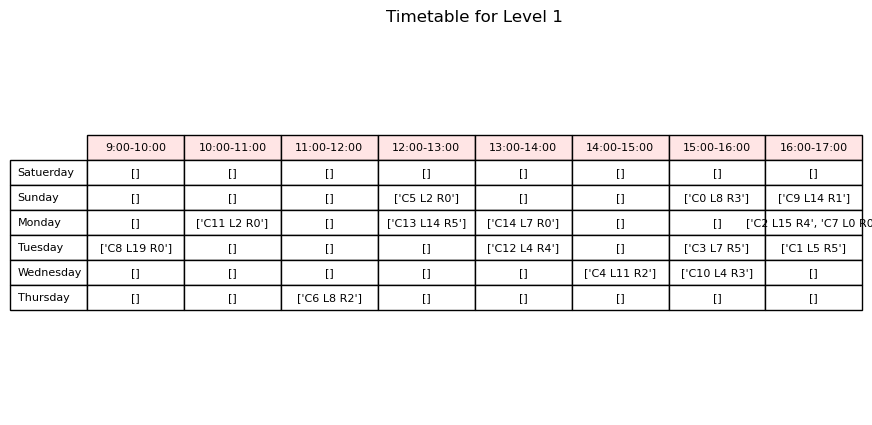

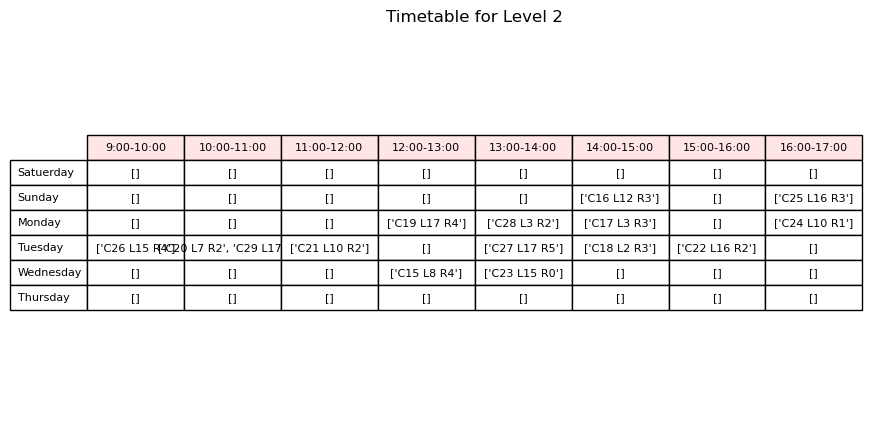

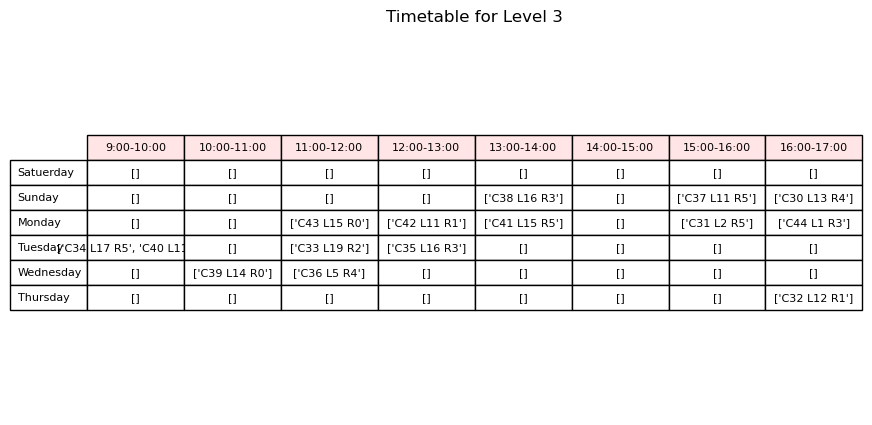

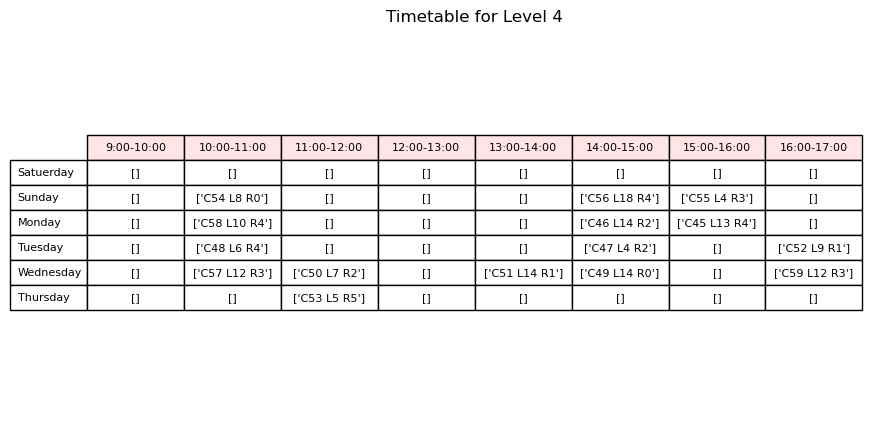

Generation: 1
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]


Generation: 10
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 19
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 28
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 37
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 46
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 55
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 64
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 73
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 82
Best Particle: [(0, 12, 5, 39), (1, 16, 5, 29), (2, 8, 1, 15), (3, 12, 2, 36), (4, 16, 4, 46), (5, 13, 2, 44), (6, 7, 1, 10), (7, 8, 4, 3), (8, 8, 3, 37), (9, 6, 3, 14), (10, 17, 0, 26), (11, 7, 4, 8), (12, 4, 1, 34), (13, 3, 3, 27), (14, 10, 2, 20), (15, 2, 3, 47), (16, 19, 2, 42), (17, 16, 2, 38), (18, 2, 3, 26), (19, 9, 1, 6), (20, 11, 1, 3), (21, 0, 1, 32), (22, 15, 1, 46), (23, 0, 3, 40), (24, 13, 5, 33), (25, 11, 5, 10), (26, 2, 3, 29), (27, 17, 4, 19), (28, 9, 4, 11), (29, 7, 0, 17), (30, 5, 1, 27), (31, 17, 4, 32), (32, 10, 4, 1), (33, 19, 2, 23), (34, 5, 3, 18), (35, 19, 1, 31), (36, 19, 1, 33), (37, 16, 5, 44), (38, 10, 3, 40), (39, 14, 0, 19), (40, 6, 5, 6), (41, 3, 5, 47), (42, 10, 2, 25), (43, 8, 4, 0), (44, 15, 3, 35), (45, 3, 0, 25), (46, 1, 1, 21), (47, 2, 5, 24), (48, 6, 1, 22), (49, 5, 1, 12), (50, 13, 3, 16), (51, 0, 4, 45), (52, 11, 5, 31), (53, 11, 0, 44), (54, 0, 3, 39), (55, 4, 5, 32), (56, 6, 1, 18), (57, 9, 4, 26), (58, 9, 4, 4), (59, 14, 5, 33)]

Generation: 91
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)]

Generation: 100
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 109
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 118
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 127
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 136
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 145
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 154
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 163
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 172
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 181
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 190
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 199
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 208
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 217
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 226
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 235
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 244
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 253
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 262
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 271
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 280
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 289
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 298
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 307
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 316
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 325
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 334
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 343
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 352
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 361
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 370
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 379
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 388
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

Generation: 397
Best Particle: [(0, 1, 5, 33), (1, 6, 1, 28), (2, 8, 1, 18), (3, 2, 0, 35), (4, 10, 0, 47), (5, 13, 3, 42), (6, 8, 1, 9), (7, 15, 3, 5), (8, 12, 1, 36), (9, 6, 0, 16), (10, 15, 1, 26), (11, 5, 2, 8), (12, 6, 2, 34), (13, 0, 3, 25), (14, 15, 3, 19), (15, 8, 3, 44), (16, 19, 4, 41), (17, 4, 0, 36), (18, 2, 4, 25), (19, 12, 4, 6), (20, 16, 4, 7), (21, 1, 5, 31), (22, 1, 5, 45), (23, 19, 5, 34), (24, 12, 4, 32), (25, 10, 3, 12), (26, 3, 5, 27), (27, 17, 5, 19), (28, 18, 5, 11), (29, 16, 4, 17), (30, 1, 4, 27), (31, 17, 4, 32), (32, 6, 5, 3), (33, 13, 2, 24), (34, 8, 2, 20), (35, 0, 2, 31), (36, 12, 1, 33), (37, 19, 1, 42), (38, 7, 0, 39), (39, 16, 2, 18), (40, 16, 4, 8), (41, 17, 2, 36), (42, 5, 3, 26), (43, 14, 1, 1), (44, 0, 1, 34), (45, 12, 1, 25), (46, 15, 1, 21), (47, 4, 5, 22), (48, 0, 4, 20), (49, 5, 4, 15), (50, 15, 0, 18), (51, 4, 1, 44), (52, 9, 0, 29), (53, 6, 5, 43), (54, 0, 3, 37), (55, 16, 3, 29), (56, 11, 0, 19), (57, 14, 4, 26), (58, 2, 4, 6), (59, 3, 5, 33)

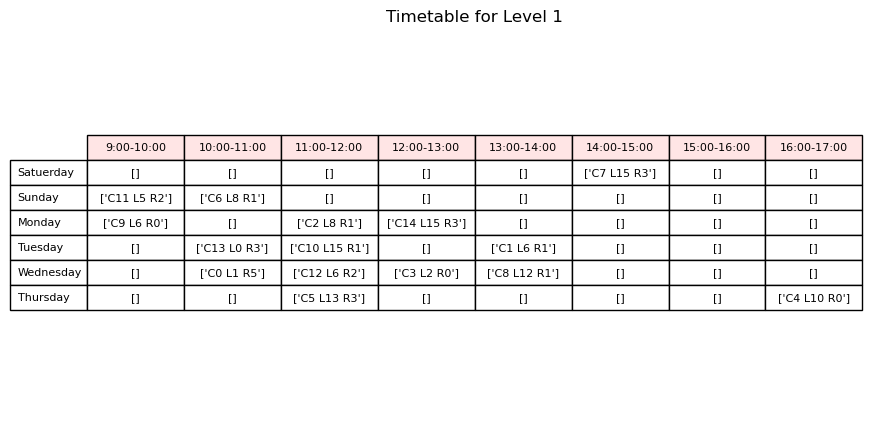

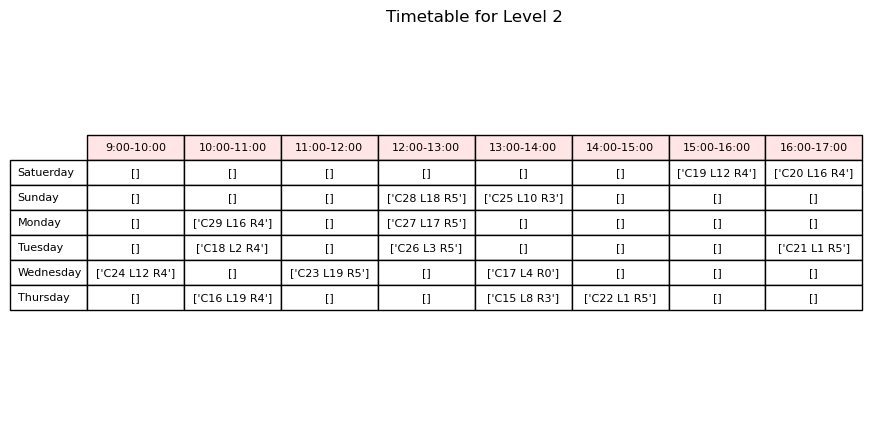

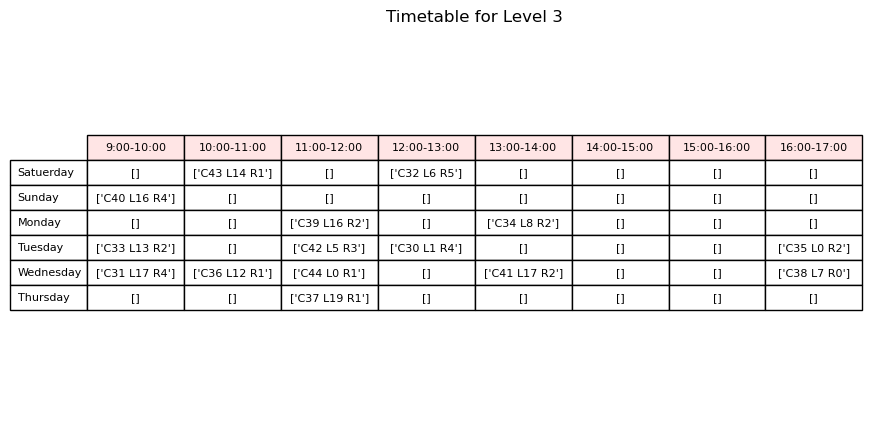

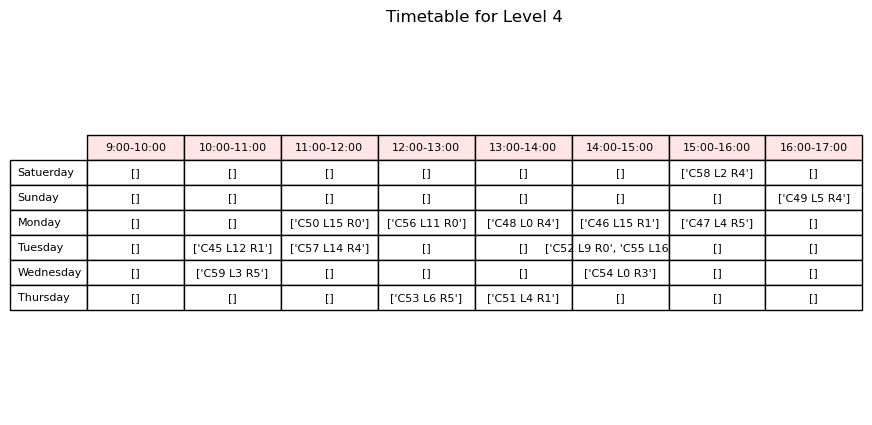

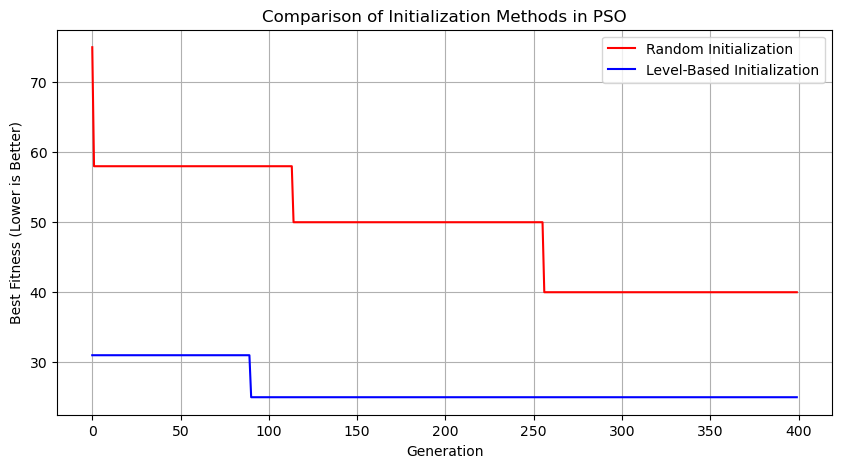

Best Solution from Random Initialization:
Course 0: Lecturer 8, Room 3, Timeslot 14
Course 1: Lecturer 5, Room 5, Timeslot 31
Course 2: Lecturer 15, Room 4, Timeslot 23
Course 3: Lecturer 7, Room 5, Timeslot 30
Course 4: Lecturer 11, Room 2, Timeslot 37
Course 5: Lecturer 2, Room 0, Timeslot 11
Course 6: Lecturer 8, Room 2, Timeslot 42
Course 7: Lecturer 0, Room 0, Timeslot 23
Course 8: Lecturer 19, Room 0, Timeslot 24
Course 9: Lecturer 14, Room 1, Timeslot 15
Course 10: Lecturer 4, Room 3, Timeslot 38
Course 11: Lecturer 2, Room 0, Timeslot 17
Course 12: Lecturer 4, Room 4, Timeslot 28
Course 13: Lecturer 14, Room 5, Timeslot 19
Course 14: Lecturer 7, Room 0, Timeslot 20
Course 15: Lecturer 8, Room 4, Timeslot 35
Course 16: Lecturer 12, Room 3, Timeslot 13
Course 17: Lecturer 3, Room 3, Timeslot 21
Course 18: Lecturer 2, Room 3, Timeslot 29
Course 19: Lecturer 17, Room 4, Timeslot 19
Course 20: Lecturer 7, Room 2, Timeslot 25
Course 21: Lecturer 10, Room 2, Timeslot 26
Course 22: Lec

In [12]:

compare_initializations(update_method='overselection')

## Investigating the effect of  2 initialisation approaches:

### By using random initialization for particles the first generation started with 75.0 conflicts and after 400 generations it reached 40.0 conflicts. 
### But by using level based initialization for particles it started with 31.0 conflicts and after 400 generations it reached 25.0

###  it appears that the level-based initialization method performs better in terms of reducing conflicts over the course of 400 generations compared to the random initialization method. The initial number of conflicts and the improvement over generations are both lower with the level-based initialization.

### This suggests that the level-based initialization method might provide a better starting point or guide for the optimization process, resulting in faster convergence towards a solution with fewer conflicts.


### while random initialization may be sufficient for some problems, level-based initialization can offer advantages in terms of leveraging domain knowledge, promoting diversity, accelerating convergence, reducing the risk of local optima, and improving the exploration-exploitation balance in the optimization process.


 1- Domain Knowledge Utilization: In many optimization problems, there is some prior knowledge available about the structure of the problem or the expected ranges of the variables. In the case of level-based initialization, this knowledge is utilized by organizing the initialization based on levels or groups, which can better align with the problem structure.

 2-Promotion of Diversity: Level-based initialization can promote diversity among the initial solutions. By organizing particles into levels or groups, you ensure that there is representation from different regions of the solution space. This can help prevent premature convergence to suboptimal solutions by exploring a wider range of possibilities from the start.

 3- Faster Convergence: In some cases, level-based initialization can lead to faster convergence compared to random initialization. This is because the initial solutions are more likely to cover different aspects of the problem space, allowing the optimization algorithm to quickly identify promising regions and focus its search efforts there.

 4-Reduced Risk of Trapping in Local Optima: Random initialization may sometimes lead particles to start in regions of the solution space that are associated with local optima or poor solutions. Level-based initialization, by contrast, distributes particles more evenly across the solution space, reducing the risk of being trapped in local optima.

 5-Improved Exploration-Exploitation Balance: Level-based initialization can help strike a better balance between exploration (searching the solution space broadly) and exploitation (refining promising solutions). By ensuring that particles are initially distributed across different levels or groups, the optimization algorithm can explore diverse regions while also exploiting promising areas identified within each level.


 Random initialization may explored a broader range of solutions across the entire search space, which could be beneficial if the optimum solution is located in a less predictable region. On the other hand, level-based initialization focuses on creating solutions that adhere to certain constraints or patterns, which could be advantageous if the optimal solutions are likely to follow those patterns.

Random initialization tends to introduce more diversity into the initial population of solutions, which can be beneficial for exploring a wide range of possibilities. Level-based initialization, while more structured, might lead to a lack of diversity in the initial solutions, potentially resulting in premature convergence to suboptimal solutions.